In [5]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt 
import math 
import itertools
import networkx as nx

class Grapher:
    """
    Description:
            This class is used to generate:
                    1) the graph (in dictionary form) { source_node: [destination_node1, destination_node2]}
                    2) the dataframe with relative_distances 

            Inputs: The class consists of a pandas dataframe consisting of cordinates for 
                    bounding boxe and the image of the invoice/receipt. 

    """

    def __init__(self, filename, data_fd):
        self.filename = filename
        self.data_fd = data_fd

        file_path = os.path.join(self.data_fd, "raw/box", filename + '.csv')
        interim_path = os.path.join(self.data_fd, "interim", filename + '.csv')
        image_path = os.path.join(self.data_fd, "raw/img", filename + '.jpg')
        self.df = pd.read_csv(file_path, header=None, sep='\n')
        self.image = cv2.imread(image_path)
        self.df_withlabels = pd.read_csv(interim_path)

    def graph_formation(self, export_graph = False):

        """
        Description:
        ===========
        Line formation:
        1) Sort words based on Top coordinate:
        2) Form lines as group of words which obeys the following:
            Two words (W_a and W_b) are in same line if:
                Top(W_a) <= Bottom(W_b) and Bottom(W_a) >= Top(W_b)
        3) Sort words in each line based on Left coordinate

        This ensures that words are read from top left corner of the image first, 
        going line by line from left to right and at last the final bottom right word of the page is read.
    
        Args: 
            df with words and cordinates (xmin,xmax,ymin,ymax)
            image read into cv2
        returns: 
            df with words arranged in orientation top to bottom and left to right, the line number for each word, index of the node connected to
            on all directions top, bottom, right and left (if they exist and satisfy the parameters provided)

        _____________________y axis______________________
        |
        |                       top    
        x axis               ___________________
        |              left | bounding box      |  right
        |                   |___________________|           
        |                       bottom 
        |
        |


        iterate through the rows twice to compare them.
        remember that the axes are inverted.
      
        """
        df, image = self.df, self.image
        """
        preprocessing the raw csv files to favorable df 
        """
        df = df[0].str.split(',', expand=True)
        temp = df.copy() 
        temp[temp.columns] = temp.apply(lambda x: x.str.strip())
        temp.fillna('', inplace=True)
        temp[8]= temp[8].str.cat(temp.iloc[:,9:], sep =", ") 
        temp[temp.columns] = temp.apply(lambda x: x.str.rstrip(", ,"))
        temp = temp.loc[:, :8]
        temp.drop([2,3,6,7], axis=1, inplace=True)
        temp.columns = ['xmin','ymin','xmax','ymax','Object']
        temp[['xmin','ymin','xmax','ymax']] = temp[['xmin','ymin','xmax','ymax']].apply(pd.to_numeric)
        df = temp 
        # *****************************************************************************************************************************
        # vao project co the bo phan chuan hoa nay
        # *****************************************************************************************************************************


        assert type(df) == pd.DataFrame,f'object_map should be of type \
            {pd.DataFrame}. Received {type(df)}'
        assert type(image) == np.ndarray,f'image should be of type {np.ndarray} \
            . Received {type(image)}'
        
        assert 'xmin' in df.columns, '"xmin" not in object map'
        assert 'xmax' in df.columns, '"xmax" not in object map'
        assert 'ymin' in df.columns, '"ymin" not in object map'
        assert 'ymax' in df.columns, '"ymax" not in object map'
        assert 'Object' in df.columns, '"Object" column not in object map'

        #remove empty spaces both in front and behind
        for col in df.columns:
            try:
                df[col] = df[col].str.strip()
            except AttributeError:
                pass

        #further cleaning
        df.dropna(inplace=True)
        #sort from top to bottom
        df.sort_values(by=['ymin'], inplace=True)
        df.reset_index(drop=True, inplace=True)

        #subtracting ymax by 1 to eliminate ambiguity of boxes being in both left and right 
        df["ymax"] = df["ymax"].apply(lambda x: x - 1)
        
        master = []
        for idx, row in df.iterrows():
            #flatten the nested list 
            flat_master = list(itertools.chain(*master))
            #check to see if idx is in flat_master
            if idx not in flat_master:
                top_a = row['ymin']
                bottom_a = row['ymax']         
                #every line will atleast have the word in it
                line = [idx]         
                for idx_2, row_2 in df.iterrows():
                    #check to see if idx_2 is in flat_master removes ambiguity
                    #picks higher cordinate one. 
                    if idx_2 not in flat_master:
                    #if not the same words
                        if not idx == idx_2:
                            top_b = row_2['ymin']
                            bottom_b = row_2['ymax'] 
                            if (top_a <= bottom_b) and (bottom_a >= top_b): 
                                line.append(idx_2)
                master.append(line)

        df2 = pd.DataFrame({'words_indices': master, 'line_number':[x for x in range(1,len(master)+1)]})
        #explode the list columns eg : [1,2,3]
        df2 = df2.set_index('line_number').words_indices.apply(pd.Series).stack()\
                .reset_index(level=0).rename(columns={0:'words_indices'})
        df2['words_indices'] = df2['words_indices'].astype('int')
        #put the line numbers back to the list
        final = df.merge(df2, left_on=df.index, right_on='words_indices')
        final.drop('words_indices', axis=1, inplace=True)

        """
        3) Sort words in each line based on Left coordinate
        """
        final2 =final.sort_values(by=['line_number','xmin'],ascending=True)\
                .groupby('line_number')\
                .head(len(final))\
                .reset_index(drop=True)
    
        df = final2 

        # print("FINAL 2 : \n ", final2.head(3))


        """
        Pseudocode:
        1) Read words from each line starting from topmost line going towards bottommost line
        2) For each word, perform the following:
            - Check words which are in vertical projection with it.
            - Calculate RD_l and RD_r for each of them 
            - Select nearest neighbour words in horizontal direction which have least magnitude of RD_l and RD_r, 
            provided that those words do not have an edge in that direciton.
                    - In case, two words have same RD_l or RD_r, the word having higher top coordinate is chosen.
            - Repeat steps from 2.1 to 2.3 similarly for retrieving nearest neighbour words in vertical direction by 
            taking horizontal projection, calculating RD_t and RD_b and choosing words having higher left co-ordinate
            incase of ambiguity
            - Draw edges between word and its 4 nearest neighbours if they are available.

        Args: 
            df after lines properly aligned
            
        returns: 
            graph in the form of a dictionary, networkX graph, dataframe with 

        """

        #horizontal edges formation
        #print(df)
        df.reset_index(inplace=True)
        grouped = df.groupby('line_number')
        #for undirected graph construction
        horizontal_connections = {}
        #left
        left_connections = {}    
        #right
        right_connections = {}

        for _,group in grouped:
            a = group['index'].tolist()
            b = group['index'].tolist()
            horizontal_connection = {a[i]:a[i+1] for i in range(len(a)-1) }
            #storing directional connections
            right_dict_temp = {a[i]:{'right':a[i+1]} for i in range(len(a)-1) }
            left_dict_temp = {b[i+1]:{'left':b[i]} for i in range(len(b)-1) }

            #add the indices in the dataframes
            for i in range(len(a)-1):
                df.loc[df['index'] == a[i], 'right'] = int(a[i+1])
                df.loc[df['index'] == a[i+1], 'left'] = int(a[i])
        
            left_connections.update(right_dict_temp)
            right_connections.update(left_dict_temp)
            horizontal_connections.update(horizontal_connection)

        dic1,dic2 = left_connections, right_connections
                
        #verticle connections formation
        bottom_connections = {}
        top_connections = {}


        for idx, row in df.iterrows():
            if idx not in bottom_connections.keys():
                right_a = row['xmax']
                left_a = row['xmin']

                for idx_2, row_2 in df.iterrows():
                    #check for higher idx values 

                    if idx_2 not in bottom_connections.values() and idx < idx_2:
                            right_b = row_2['xmax']
                            left_b = row_2['xmin'] 
                            if (left_b <= right_a) and (right_b >= left_a): 
                                bottom_connections[idx] = idx_2                
                                top_connections[idx_2] = idx

                                #add it to the dataframe
                                df.loc[df['index'] == idx , 'bottom'] = idx_2
                                df.loc[df['index'] == idx_2, 'top'] = idx 
                                #print(bottom_connections)
                                #once the condition is met, break the loop to reduce redundant time complexity
                                break 
                        
        #combining both 
        result = {}
        dic1 = horizontal_connections
        dic2 = bottom_connections

        for key in (dic1.keys() | dic2.keys()):
            if key in dic1: result.setdefault(key, []).append(dic1[key])
            if key in dic2: result.setdefault(key, []).append(dic2[key])

        G = nx.from_dict_of_lists(result)
        
        if export_graph:

            if not os.path.exists('./figures/graphs'):
                os.makedirs('./figures/graphs')			
           
            plot_path ='./figures/graphs/' + self.filename + 'plain_graph' '.jpg'
            # print(plot_path)
            layout = nx.kamada_kawai_layout(G)   
            layout = nx.spring_layout(G)     
            nx.draw(G, layout, with_labels=True)
            plt.savefig(plot_path, format="PNG", dpi=600)
            #plt.show()

        # connect with the interim file that has labels in it
        df['labels'] = self.df_withlabels['9']
        self.df = df 


        return G,result, df 

    #features calculation    
    def get_text_features(self, df): 
        """
        gets text features 

        Args: df
        Returns: n_lower, n_upper, n_spaces, n_alpha, n_numeric,n_special
        """
        data = df['Object'].tolist()
        
        '''
            Args:
                df
                
            Returns: 
                character and word features
                
        '''
        special_chars = ['&', '@', '#', '(',')','-','+', 
                    '=', '*', '%', '.', ',', '\\','/', 
                    '|', ':']

        # character wise
        n_lower, n_upper, n_spaces, n_alpha, n_numeric,n_special = [],[],[],[],[],[]

        for words in data:
            lower, upper,alpha,spaces,numeric,special = 0,0,0,0,0,0
            for char in words: 
                if char.islower():
                    lower += 1
                # for upper letters 
                if char.isupper(): 
                    upper += 1
                # for white spaces
                if char.isspace():
                    spaces += 1               
                # for alphabetic chars
                if char.isalpha():
                    alpha += 1  
                # for numeric chars
                if char.isnumeric():
                    numeric += 1                            
                if char in special_chars:
                    special += 1 

            n_lower.append(lower)
            n_upper.append(upper)
            n_spaces.append(spaces)
            n_alpha.append(alpha)
            n_numeric.append(numeric)
            n_special.append(special)
            #features.append([n_lower, n_upper, n_spaces, n_alpha, n_numeric, n_digits])

        df['n_upper'],df['n_alpha'],df['n_spaces'], df['n_numeric'],df['n_special'] = n_upper, n_alpha, n_spaces, n_numeric,n_special
        # self.df = df
        return df

    def relative_distance(self, export_document_graph = False):
        """ 
        1) Calculates relative distances for each node in left, right, top  and bottom directions if they exist.
        rd_l, rd_r = relative distances left , relative distances right. The distances are divided by image width
        rd_t, rd_b = relative distances top , relative distances bottom. The distances are divided by image length

        2) Exports the complete document graph for visualization

        Args: 
            result dataframe from graph_formation()
             
        returns: 
            dataframe with features and exports document graph if prompted
        """

        df, img = self.df, self.image
        image_height, image_width = self.image.shape[0], self.image.shape[1]
        plot_df = df.copy() 

        for index in df['index'].to_list():
            right_index = df.loc[df['index'] == index, 'right'].values[0]
            left_index = df.loc[df['index'] == index, 'left'].values[0]
            bottom_index = df.loc[df['index'] == index, 'bottom'].values[0]
            top_index = df.loc[df['index'] == index, 'top'].values[0]

            #check if it is nan value 
            if np.isnan(right_index) == False: 
                right_word_left = df.loc[df['index'] == right_index, 'xmin'].values[0]
                source_word_right = df.loc[df['index'] == index, 'xmax'].values[0]
                df.loc[df['index'] == index, 'rd_r'] = (right_word_left - source_word_right)/image_width

                """
                for plotting purposes
                getting the mid point of the values to draw the lines for the graph
                mid points of source and destination for the bounding boxes
                """
                right_word_x_max = df.loc[df['index'] == right_index, 'xmax'].values[0]
                right_word_y_max = df.loc[df['index'] == right_index, 'ymax'].values[0]
                right_word_y_min = df.loc[df['index'] == right_index, 'ymin'].values[0]

                df.loc[df['index'] == index, 'destination_x_hori'] = (right_word_x_max + right_word_left)/2
                df.loc[df['index'] == index, 'destination_y_hori'] = (right_word_y_max + right_word_y_min)/2

            if np.isnan(left_index) == False:
                left_word_right = df.loc[df['index'] == left_index, 'xmax'].values[0]
                source_word_left = df.loc[df['index'] == index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'rd_l'] = (left_word_right - source_word_left)/image_width
            
            if np.isnan(bottom_index) == False:
                bottom_word_top = df.loc[df['index'] == bottom_index, 'ymin'].values[0]
                source_word_bottom = df.loc[df['index'] == index, 'ymax'].values[0]
                df.loc[df['index'] == index, 'rd_b'] = (bottom_word_top - source_word_bottom)/image_height

                """for plotting purposes"""
                bottom_word_top_max = df.loc[df['index'] == bottom_index, 'ymax'].values[0]
                bottom_word_x_max = df.loc[df['index'] == bottom_index, 'xmax'].values[0]
                bottom_word_x_min = df.loc[df['index'] == bottom_index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'destination_y_vert'] = (bottom_word_top_max + bottom_word_top)/2
                df.loc[df['index'] == index, 'destination_x_vert'] = (bottom_word_x_max + bottom_word_x_min)/2
                
            if np.isnan(top_index) == False:
                top_word_bottom = df.loc[df['index'] == top_index, 'ymax'].values[0]
                source_word_top = df.loc[df['index'] == index, 'ymin'].values[0]
                df.loc[df['index'] == index, 'rd_t'] = (top_word_bottom - source_word_top)/image_height

        #replace all tne NaN values with '0' meaning there is nothing in that direction
        df[['rd_r','rd_b','rd_l','rd_t']] = df[['rd_r','rd_b','rd_l','rd_t']].fillna(0)

        if export_document_graph:
            for idx, row in df.iterrows():
        #bounding box
                cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 255), 2)

                if np.isnan(row['destination_x_vert']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2
                    
                    cv2.line(img, 
                            (int(source_x), int(source_y)),
                            (int(row['destination_x_vert']), int(row['destination_y_vert'])), 
                            (0,255,0), 2)


                    text = "{:.3f}".format(row['rd_b'])
                    text_coordinates = ( int((row['destination_x_vert'] + source_x)/2) , int((row['destination_y_vert'] +source_y)/2))     
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

                    #text_coordinates = ((row['destination_x_vert'] + source_x)/2 , (row['destination_y_vert'] +source_y)/2)
                
                if np.isnan(row['destination_x_hori']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2

                    cv2.line(img, 
                        (int(source_x), int(source_y)),
                        (int(row['destination_x_hori']), int(row['destination_y_hori'])), \
                        (0,255,0), 2)

                    text = "{:.3f}".format(row['rd_r'])
                    text_coordinates = (int((row['destination_x_hori'] + source_x)/2) , int((row['destination_y_hori'] +source_y)/2))     
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

            # cv2.imshow("image", img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
                if not os.path.exists('../../figures/graphs'):
                    os.makedirs('../../figures/graphs')			
                    
                plot_path ='../../figures/graphs/' + self.filename + 'docu_graph' '.jpg'
                cv2.imwrite(plot_path, img)
   
        #drop the unnecessary columns
        df.drop(['destination_x_hori', 'destination_y_hori','destination_y_vert','destination_x_vert'], axis=1, inplace=True)
        self.get_text_features(df)
        return df

# if __name__ == "__main__":
#     file = '339'
#     connect = Grapher(file)
#     G,result, df = connect.graph_formation(export_graph=True)
#     df = connect.relative_distance(export_document_graph = True)
1

1

In [6]:
# from Grapher import Grapher

array([nan, 'company', 'address', 'invoice', 'date', 'total'],
      dtype=object)

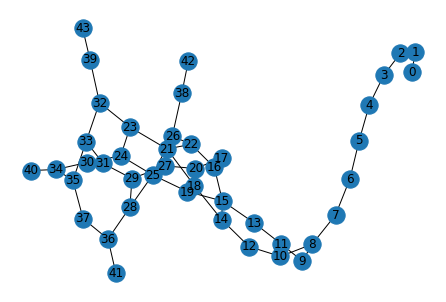

In [7]:
file = '000'

data_fd =  "./raw_sroie"
connect = Grapher(file, data_fd)
G,result, df = connect.graph_formation(export_graph=True)
df.info
df.labels.unique()
# df = connect.relative_distance(export_document_graph = True)

In [8]:
connect.get_text_features(df).head()

,index,xmin,ymin,xmax,ymax,Object,line_number,right,left,bottom,top,labels,n_upper,n_alpha,n_spaces,n_numeric,n_special
0,0,72,25,326,63,TAN WOON YANN,1,NaN,NaN,1.0,NaN,NaN,11,11,2,0,0
1,1,50,82,440,120,BOOK TA .K(TAMAN DAYA) SDN BND,2,NaN,NaN,2.0,0.0,company,22,22,5,0,3
2,2,205,121,285,138,789417-W,3,NaN,NaN,3.0,1.0,NaN,1,1,0,6,1
3,3,110,144,383,162,"NO.53 55, 57 & 59, JALAN SAGU 18",4,NaN,NaN,4.0,2.0,address,11,11,7,10,4
4,4,192,169,299,186,TAMAN DAYA,5,NaN,NaN,5.0,3.0,address,9,9,1,0,0


In [9]:
connect.relative_distance().head()

,index,xmin,ymin,xmax,ymax,Object,line_number,right,left,bottom,...,labels,n_upper,n_alpha,n_spaces,n_numeric,n_special,rd_b,rd_t,rd_r,rd_l
0,0,72,25,326,63,TAN WOON YANN,1,NaN,NaN,1.0,...,NaN,11,11,2,0,0,0.018756,0.000000,0.0,0.0
1,1,50,82,440,120,BOOK TA .K(TAMAN DAYA) SDN BND,2,NaN,NaN,2.0,...,company,22,22,5,0,3,0.000987,-0.018756,0.0,0.0
2,2,205,121,285,138,789417-W,3,NaN,NaN,3.0,...,NaN,1,1,0,6,1,0.005923,-0.000987,0.0,0.0
3,3,110,144,383,162,"NO.53 55, 57 & 59, JALAN SAGU 18",4,NaN,NaN,4.0,...,address,11,11,7,10,4,0.006910,-0.005923,0.0,0.0
4,4,192,169,299,186,TAMAN DAYA,5,NaN,NaN,5.0,...,address,9,9,1,0,0,0.006910,-0.006910,0.0,0.0


In [10]:
# df.to_csv('./data_check/graph_demo.csv')

In [11]:
import torch 
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from bpemb import BPEmb
from sentence_transformers import SentenceTransformer
import random
import os 
import glob
import numpy as np
import pandas as pd
torch.cuda.empty_cache()

bpemb_en = BPEmb(lang="en", dim=100)
sent_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device='cuda:0')


data_fd =  "./raw_sroie"

from tqdm import tqdm_notebook

def make_sent_bert_features(text):
    emb = sent_model.encode([text])[0]
    return emb

def listdir_nohidden(path):
    file_path_list =  glob.glob(os.path.join(path, '*'))
    # get file name by os.path.basename
    file_name_list = [os.path.basename(file_path) for file_path in file_path_list]
    # remove .csv from file name
    file_name_list = [file_name.split('.')[0] for file_name in file_name_list]
    return file_name_list



def get_data(save_fd):
    """
    returns one big graph with unconnected graphs with the following:
    - x (Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)
    - edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)
    - edge_attr (Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)
    - y (Tensor, optional) – Graph or node targets with arbitrary shape. (default: None)
    - validation mask, training mask and testing mask 
    """
    path = "./raw_sroie/raw/box"
    
    
    # files = [i.split('.')[0] for i in os.listdir(path)]
    files = listdir_nohidden(path)

    files.sort()
    all_files = files[1:]

    list_of_graphs = []
    train_list_of_graphs, test_list_of_graphs = [], []

    files = all_files.copy()
    random.shuffle(files)

    """Resulting in 550 receipts for training"""
    training, testing = files[:550], files[550:]

    for file in tqdm_notebook(all_files):
        # print(file)
        # break
        
        connect = Grapher(file, data_fd)
        # try:
        G,_,_ = connect.graph_formation()
        # except:
        #     print(" lOOIXXXXXXXXXXXXXXXXXXXXXXXXX")
        #     print("file name  = ", file) 
        #     continue

        df = connect.relative_distance() 

        individual_data = from_networkx(G)

        feature_cols = ['rd_b', 'rd_r', 'rd_t', 'rd_l','line_number', \
                'n_upper', 'n_alpha', 'n_spaces', 'n_numeric','n_special']

        text_features = np.array(df["Object"].map(make_sent_bert_features).tolist()).astype(np.float32)
        numeric_features = df[feature_cols].values.astype(np.float32)

        features = np.concatenate((numeric_features, text_features), axis=1) 
        features = torch.tensor(features)

        for col in df.columns:
            try:
                df[col] = df[col].str.strip()
            except AttributeError as e:
                pass

        df['labels'] = df['labels'].fillna('undefined')
        df.loc[df['labels'] == 'company', 'num_labels'] = 1
        df.loc[df['labels'] == 'address', 'num_labels'] = 2
        df.loc[df['labels'] == 'date', 'num_labels'] = 3
        df.loc[df['labels'] == 'total', 'num_labels'] = 4
        df.loc[df['labels'] == 'undefined', 'num_labels'] = 5
        # fillna df.['num_labels'] by 5
        df['num_labels'] = df['num_labels'].fillna(5)
 
        # assert df['num_labels'].isnull().values.any() == False, f'labeling error! Invalid label(s) present in {file}.csv'
        # print("####################################3")
        # print(df.columns)
        # print(df.iloc[7])
        
        assert df['num_labels'].isnull().values.any() == False, f'labeling error! Invalid label(s) present in {file}.csv'
        labels = torch.tensor(df['num_labels'].values.astype(np.int64))
        text = df['Object'].values

        # print(df["labels"])

        individual_data.x = features
        individual_data.y = labels
        individual_data.text = text
        individual_data.img_id = file

        if file in training:
            train_list_of_graphs.append(individual_data)
        elif file in testing:
            test_list_of_graphs.append(individual_data)

    train_data = torch_geometric.data.Batch.from_data_list(train_list_of_graphs)
    train_data.edge_attr = None
    test_data = torch_geometric.data.Batch.from_data_list(test_list_of_graphs)
    test_data.edge_attr = None
    

    torch.save(train_data, os.path.join(save_fd, 'train_data.dataset'))
    torch.save(test_data, os.path.join(save_fd, 'test_data.dataset'))

get_data(save_fd="./raw_sroie/processed")


/home/long/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0     undefined
1       company
2       address
3       address
4       address
5     undefined
6     undefined
7     undefined
8          date
9     undefined
10    undefined
11    undefined
12    undefined
13    undefined
14    undefined
15    undefined
16    undefined
17    undefined
18    undefined
19    undefined
20    undefined
21    undefined
22    undefined
23    undefined
24    undefined
25    undefined
26    undefined
27    undefined
28    undefined
29    undefined
30    undefined
31    undefined
32    undefined
33    undefined
34    undefined
35    undefined
36    undefined
37    undefined
38        total
39    undefined
40    undefined
41    undefined
42    undefined
43    undefined
44    undefined
45    undefined
46    undefined
47    undefined
Name: labels, dtype: object
0     undefined
1       company
2     undefined
3       address
4       address
5       address
6     undefined
7     undefined
8     undefined
9     undefined
10    undefined
11    undefined
12    undefi

KeyboardInterrupt: 

In [ ]:
import torch.nn as nn
# import class ChebConv
from torch_geometric.nn import ChebConv
# import class GraphConv
from torch_geometric.nn import GraphConv
# import class GCNConv
from torch_geometric.nn import GCNConv

# import class torch.nn.functional as F
import torch.nn.functional as F


class InvoiceGCN(nn.Module):

    def __init__(self, input_dim, chebnet=False, n_classes=5, dropout_rate=0.2, K=3):
        super().__init__()

        self.input_dim = input_dim
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate

        if chebnet:
            self.conv1 = ChebConv(self.input_dim, 64, K=K)
            self.conv2 = ChebConv(64, 32, K=K)
            self.conv3 = ChebConv(32, 16, K=K)
            self.conv4 = ChebConv(16, self.n_classes, K=K)
        else:
            self.conv1 = GCNConv(self.first_dim, 64, improved=True, cached=True)
            self.conv2 = GCNConv(64, 32, improved=True, cached=True)
            self.conv3 = GCNConv(32, 16, improved=True, cached=True)
            self.conv4 = GCNConv(16, self.n_classes, improved=True, cached=True)

    def forward(self, data):
        # for transductive setting with full-batch update
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = F.dropout(F.relu(self.conv1(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = F.dropout(F.relu(self.conv2(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = F.dropout(F.relu(self.conv3(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = self.conv4(x, edge_index, edge_weight)

        return F.log_softmax(x, dim=1)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# import confution matrix
from sklearn.metrics import confusion_matrix
#import clasiification report
from sklearn.metrics import classification_report
import torch

save_fd = "./raw_sroie/processed"
train_data, test_data = torch.load(os.path.join(save_fd, 'train_data.dataset')), torch.load(os.path.join(save_fd, 'test_data.dataset'))

model = InvoiceGCN(input_dim=train_data.x.shape[1], chebnet=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.001, weight_decay=0.9
)
train_data = train_data.to(device)
test_data = test_data.to(device)

# class weights for imbalanced data
_class_weights = compute_class_weight(class_weight= "balanced", classes= train_data.y.unique().cpu().numpy(), y = train_data.y.cpu().numpy())
# print(_class_weights)

no_epochs = 2000
for epoch in range(1, no_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # NOTE: just use boolean indexing to filter out test data, and backward after that!
    # the same holds true with test data :D
    # https://github.com/rusty1s/pytorch_geometric/issues/1928
    loss = F.nll_loss(
        model(train_data), train_data.y - 1, weight=torch.FloatTensor(_class_weights).to(device)
    )
    loss.backward()
    optimizer.step()

    # calculate acc on 5 classes
    with torch.no_grad():
        if epoch % 200 == 0:
            model.eval()

            # forward model
            for index, name in enumerate(['train', 'test']):
                _data = eval("{}_data".format(name))
                y_pred = model(_data).max(dim=1)[1]
                y_true = (_data.y - 1)
                acc = y_pred.eq(y_true).sum().item() / y_pred.shape[0]

                y_pred = y_pred.cpu().numpy()
                y_true = y_true.cpu().numpy()
                print("\t{} acc: {}".format(name, acc))
                # confusion matrix
                if name == 'test':
                    cm = confusion_matrix(y_true, y_pred)
                    class_accs = cm.diagonal() / cm.sum(axis=1)
                    print(classification_report(y_true, y_pred))

            loss_val = F.nll_loss(model(test_data), test_data.y - 1
            )
            fmt_log = "Epoch: {:03d}, train_loss:{:.4f}, val_loss:{:.4f}"
            print(fmt_log.format(epoch, loss, loss_val))
            print(">" * 50)


In [ ]:
test_output_fd = "/raw_sroie/test_output"


# import tqdm in notebook
from tqdm import tqdm
import time 
# import Counter
from collections import Counter
import cv2
import matplotlib.pyplot as plt

img_fd = "./raw_sroie/raw/img/"

import shutil
shutil.rmtree(test_output_fd)
if not os.path.exists(test_output_fd):
    os.mkdir(test_output_fd)

def make_info(img_id='584'):
    connect = Grapher(img_id, data_fd)
    G, _, _ = connect.graph_formation()
    df = connect.relative_distance()
    individual_data = from_networkx(G)
    img = cv2.imread(os.path.join(img_fd, "{}.jpg".format(img_id)))[:, :, ::-1]

    return G, df, individual_data, img

y_preds = model(test_data).max(dim=1)[1].cpu().numpy()
LABELS = ["company", "address", "date", "total", "other"]
test_batch = test_data.batch.cpu().numpy()
indexes = range(len(test_data.img_id))
for index in tqdm(indexes):
    start = time.time()
    img_id = test_data.img_id[index]  # not ordering by img_id
    sample_indexes = np.where(test_batch == index)[0]
    y_pred = y_preds[sample_indexes]

    print("Img index: {}".format(index))
    print("Img id: {}".format(img_id))
    print("y_pred: {}".format(Counter(y_pred)))
    G, df, individual_data, img = make_info(img_id)

    assert len(y_pred) == df.shape[0]

    img2 = np.copy(img)
    for row_index, row in df.iterrows():
        x1, y1, x2, y2 = row[['xmin', 'ymin', 'xmax', 'ymax']]
        true_label = row["labels"]

        if isinstance(true_label, str) and true_label != "invoice":
            cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 255, 0), 2)

        _y_pred = y_pred[row_index]
        if _y_pred != 4:
            cv2.rectangle(img2, (x1, y1), (x2, y2), (255, 0, 0), 3)
            _label = LABELS[_y_pred]
            cv2.putText(
                img2, "{}".format(_label), (x1, y1),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2
            )

    end = time.time()
    print("\tImage {}: {}".format(img_id, end - start))
    plt.imshow(img2)
    plt.savefig(os.path.join(test_output_fd, '{}_result.png'.format(img_id)), bbox_inches='tight')
    plt.savefig('{}_result.png'.format(img_id), bbox_inches='tight')
